<a href="https://colab.research.google.com/github/leramorozova/compling_and_infotech/blob/master/assignment_6/assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6

[3 points] Delelop language model, which generates texts from wikipedia.   
Use WikiText-2 dataset, also available in `torchtext.datasets`.  
Use `sentencepiece` or `tokenizers` library for text tokenization. Pay attention to vocab size, probably subword tokens are better.    
Your model should be autogressive RNN.  
[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.  
[1 point] Try to use together (`sentencepiece` or `tokenizers`), `torchtext.datasets`, and `torchtext.data.BPTTIterator`  

<img src="./images/lm.jpg" style="height:300px">

Text generation should be terminated when either max length is reached or terminal symbol is generated.  
Explore several inference techniques:
1. [1 point] Argmax
1. [1 point] Beamsearch
1. [1 point] Sampling from probabilty distribution with temperature
1. [1 point] Nucleus sampling
1. [1 point] Top-k sampling


For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

Readings:
https://arxiv.org/abs/1904.09751

In [1]:
from torchtext.datasets import WikiText2

WikiText2.download("./data")

'./data/wikitext-2/wikitext-2'

In [2]:
import os

with open(os.path.join(".", "data", "wikitext-2", "wikitext-2", "wiki.test.tokens"), "r") as test_fd:
    test_data = test_fd.read()

test_data[:300]

' \n = Robert <unk> = \n \n Robert <unk> is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court The'

In [3]:
with open(os.path.join(".", "data", "wikitext-2", "wikitext-2", "wiki.train.tokens"), "r") as train_fd:
    train_data = train_fd.read()

train_data[:300]

' \n = Valkyria Chronicles III = \n \n Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStatio'

In [4]:
with open(os.path.join(".", "data", "wikitext-2", "wikitext-2", "wiki.valid.tokens"), "r") as valid_fd:
    valid_data = valid_fd.read()

valid_data[:300]

' \n = Homarus gammarus = \n \n Homarus gammarus , known as the European lobster or common lobster , is a species of <unk> lobster from the eastern Atlantic Ocean , Mediterranean Sea and parts of the Black Sea . It is closely related to the American lobster , H. americanus . It may grow to a length of 6'

Хочу убрать из данных все непонятные символы (спец символы, иероглифы), чтобы они не предсказывались моделью.

In [0]:
from string import ascii_letters
import re

eos = ["\n", "\t", ".", "?", "!"]

other_friendly_punct = [",", ":", ";"]

def prepare_text(input_text):
    clean_text = ""
    input_text = re.sub("<unk>", "", input_text)
    for s in input_text:
        if s in ascii_letters or s in eos:
            clean_text += s
        elif s in other_friendly_punct:
            clean_text += ","
        elif s == " ":
            clean_text += " "
    
    clean_text = re.sub("\s+", " ", clean_text)
    clean_text = re.sub("[\n\t\.?!]", "<eos> <sos>", clean_text)
    clean_text = re.sub("\s+", " ", clean_text)
    while re.search("<eos> <sos>\s+<eos> <sos>", clean_text):
      clean_text = re.sub("<eos> <sos>\s+<eos> <sos>", "<eos> <sos>", clean_text)
      clean_text = re.sub("\s+", " ", clean_text)
    clean_text = re.sub("\s+", " ", clean_text)
    clean_text = '<sos> ' + clean_text
    idx = clean_text.rfind("<sos>")
    return clean_text[:idx].lower()

In [6]:
print(train_data[3000:10000])
clean_train = prepare_text(train_data)
print(clean_train[3000:10000])

o main <unk> , although they take a very minor role . 
 The game 's battle system , the <unk> system , is carried over directly from <unk> Chronicles . During missions , players select each unit using a top @-@ down perspective of the battlefield map : once a character is selected , the player moves the character around the battlefield in third @-@ person . A character can only act once per @-@ turn , but characters can be granted multiple turns at the expense of other characters ' turns . Each character has a field and distance of movement limited by their Action <unk> . Up to nine characters can be assigned to a single mission . During gameplay , characters will call out if something happens to them , such as their health points ( HP ) getting low or being knocked out by enemy attacks . Each character has specific " Potentials " , skills unique to each character . They are divided into " Personal Potential " , which are innate skills that remain unaltered unless otherwise dictated by

In [0]:
with open(os.path.join(".", "data", "clean_train.tokens"), "w", encoding="UTF-8") as clean_fd:
    clean_fd.write(clean_train)

with open(os.path.join(".", "data", "clean_test.tokens"), "w", encoding="UTF-8") as clean_fd:
    clean_fd.write(prepare_text(test_data))

In [8]:
!pip install tokenizers

In [0]:
from tokenizers import SentencePieceBPETokenizer

Обучаю токенизатор и на тренировочных, и на тестовых данных, т.к. тестовые данные мы в данной работе использовать не будем, только валидационные.

In [0]:
train_tokenizer = SentencePieceBPETokenizer()
train_tokenizer.add_special_tokens(["<eos>", "<unk>", "<sos>"])
train_tokenizer.train([os.path.join(".", "data", "clean_train.tokens"), os.path.join(".", "data", "clean_test.tokens")], vocab_size=20000)

In [11]:
train_tokenizer

Tokenizer(vocabulary_size=20003, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [12]:
print(prepare_text("Hahahahah ! ! ! Its me ."))
out = train_tokenizer.encode(prepare_text("Hahahahah ! ! ! Its me ."))
print(out.ids)
print(out.tokens)

<sos> hahahahah <eos> <sos> its me <eos> 
[2, 74, 1000, 1000, 1000, 1000, 32, 0, 32, 2, 259, 347, 32, 0, 32]
['<sos>', '▁h', 'ah', 'ah', 'ah', 'ah', '▁', '<eos>', '▁', '<sos>', '▁its', '▁me', '▁', '<eos>', '▁']


In [13]:
train_tokenizer.token_to_id("<eos>")

0

In [0]:
def tokenize(sent):
    sent = prepare_text(sent)
    return train_tokenizer.encode(sent).tokens

In [0]:
import torchtext
from torchtext.datasets import LanguageModelingDataset

TXT = torchtext.data.Field(lower=True, include_lengths=False, batch_first=False, 
                           tokenize=lambda sent: tokenize(sent))

In [0]:
train_data, val_data, test_data = WikiText2.splits(TXT)

In [17]:
print(train_data)

In [0]:
from torchtext.data import BPTTIterator
import torch as tt

TXT.build_vocab(train_data, val_data, test_data, min_freq=5)

train_iter, val_iter, test_iter = BPTTIterator.splits((train_data, val_data, test_data),
            batch_size=128, bptt_len=50, repeat=False, device=tt.device("cuda"))

In [19]:
help(train_iter)

Help on BPTTIterator in module torchtext.data.iterator object:

class BPTTIterator(Iterator)
 |  Defines an iterator for language modeling tasks that use BPTT.
 |  
 |  Provides contiguous streams of examples together with targets that are
 |  one timestep further forward, for language modeling training with
 |  backpropagation through time (BPTT). Expects a Dataset with a single
 |  example and a single field called 'text' and produces Batches with text and
 |  target attributes.
 |  
 |  Attributes:
 |      dataset: The Dataset object to load Examples from.
 |      batch_size: Batch size.
 |      bptt_len: Length of sequences for backpropagation through time.
 |      sort_key: A key to use for sorting examples in order to batch together
 |          examples with similar lengths and minimize padding. The sort_key
 |          provided to the Iterator constructor overrides the sort_key
 |          attribute of the Dataset, or defers to it if None.
 |      train: Whether the iterator rep

In [0]:
btc = next(iter(train_iter))

In [21]:
def recover_text(vector):
    return [TXT.vocab.itos[v] for v in vector[0]]

print(recover_text(btc.text.data.squeeze()))

print(recover_text(btc.target.data.squeeze()))

['▁', '▁amateur', '▁is', '▁', 'ing', '▁,', '▁unc', '▁,', '▁in', '▁audience', '▁"', '<eos>', '▁,', '▁western', 's', '▁', '▁', '▁as', '▁drumming', '▁features', '▁a', '▁cow', 'osp', '▁th', '<eos>', '▁to', '▁,', '▁recommended', '▁,', '▁had', '▁', '<eos>', '▁all', '▁that', '▁as', '▁latin', '▁carried', '▁the', '▁', '▁presided', '▁the', '▁', '▁previously', '▁the', '▁same', '▁incurred', '▁longer', '▁oldham', '▁is', '▁required', '▁at', '<sos>', '▁containing', '▁because', '▁troops', '▁on', '<sos>', '▁cage', '▁corridor', 'le', '▁february', '<sos>', '▁gothic', '<eos>', '▁mexico', '▁good', '▁may', '▁also', "▁'s", '▁and', '▁would', '▁called', "▁'", '▁due', "▁'s", '▁riaa', '▁of', '▁popularised', '▁highway', '▁into', '▁', '▁northeast', '▁north', '▁tigers', '▁,', "▁'s", '▁reputation', '▁its', '▁on', '▁and', '▁when', '▁being', '▁jar', '▁officially', '▁the', '<eos>', '▁goals', '▁', '▁', '▁of', '▁', '▁declined', '▁part', '▁his', '▁waiting', '▁,', '▁radio', '▁', '▁to', '<eos>', '▁the', '▁reached', 'erson',

In [22]:
btc.text

tensor([[   2, 3131,   21,  ..., 2139,   33,  276],
        [   4,  873,   40,  ...,  906, 2525, 9090],
        [   2,    2,  142,  ..., 2431,   21,    5],
        ...,
        [   8, 4281,  142,  ...,   42,    3,   26],
        [ 941,  262,   10,  ..., 2861, 5325, 1574],
        [   4,   51,   31,  ...,   33, 2238,   13]], device='cuda:0')

In [23]:
btc.target

tensor([[   4,  873,   40,  ...,  906, 2525, 9090],
        [   2,    2,  142,  ..., 2431,   21,    5],
        [   4,    4,   10,  ...,  628, 5567, 1579],
        ...,
        [ 941,  262,   10,  ..., 2861, 5325, 1574],
        [   4,   51,   31,  ...,   33, 2238,   13],
        [   2,    3,  596,  ..., 3133,   99,   71]], device='cuda:0')

In [0]:
import torch.nn as nn
import torch as tt

class AutoRegressive(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(AutoRegressive, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        
        x = batch.text.T if hasattr(batch, "text") else batch
        # total_length = x.size(1)
        
        x = self.embedding(x)

        # if x_lengths is not None:
        #     x_lengths = x_lengths.view(-1).tolist()
        #     x = nn.utils.rnn.pack_padded_sequence(x, x_lengths, batch_first=True)
            
        x, _ = self.rnn(x)
        
        # x, _ = nn.utils.rnn.pad_packed_sequence(x, total_length=total_length, batch_first=True)
        
        # x = x.contiguous().view(batch_size * total_length, -1)
        x = self.fc(x)
        # x = x.contiguous().view(batch_size , total_length, -1)
        return x.transpose(1,2)

In [0]:
import torch.optim as optim

model = AutoRegressive(len(TXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [0]:
import numpy as np

def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch)
      
        loss = criterion(pred, batch.target.T)
        loss.backward()
        optimizer.step()

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i + 1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss

In [0]:
def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    with tt.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches

In [0]:
def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):
  
    model = model.cuda()
    criterion = criterion.cuda()

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    for epoch in range(n_epochs):
        train_loss = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss = _test_epoch(model, valid_iterator, criterion)

        valid_loss = valid_loss
        print('epoch %d, validation loss %.5f' % (epoch, valid_loss))
        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history

In [29]:
import pandas as pd
from tqdm import tqdm_notebook

history = nn_train(model, train_iter, val_iter, criterion, optimizer, scheduler=scheduler, 
        n_epochs=15, early_stopping=2)


epoch 0, validation loss 5.00773



epoch 1, validation loss 3.82244



epoch 2, validation loss 3.05926



epoch 3, validation loss 2.53784



epoch 4, validation loss 2.10542



epoch 5, validation loss 1.72298



epoch 6, validation loss 1.39916



epoch 7, validation loss 1.14166



epoch 8, validation loss 0.93971



epoch 9, validation loss 0.78275



epoch 10, validation loss 0.65961



epoch 11, validation loss 0.56240



epoch 12, validation loss 0.48561



epoch 13, validation loss 0.42508



epoch 14, validation loss 0.37704


In [30]:
history.head()

,epoch,train_loss,valid_loss
0,0.0,6.091898,5.007725
1,1.0,4.548311,3.822435
2,2.0,3.538312,3.059262
3,3.0,2.890490,2.537840
4,4.0,2.391812,2.105416


In [31]:
list(history["train_loss"])

[6.091898164749148,
 4.548311414718634,
 3.5383122164862497,
 2.890490118435448,
 2.3918115370614155,
 1.956289779118129,
 1.5738451395715982,
 1.2567756411007456,
 1.0023146387508945,
 0.8017556592396327,
 0.6445908781460353,
 0.5213251067059387,
 0.42502144975321654,
 0.35000072734696525,
 0.29170964428356705]

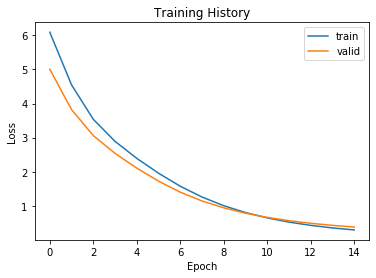

In [32]:
import matplotlib.pyplot as plt

plt.plot(list(history["train_loss"]))
plt.plot(list(history["valid_loss"]))
plt.legend(('train', 'valid'))
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [0]:
model = model.cpu()

In [0]:
def recover_text(vector):
    return [train_tokenizer.id_to_token(idx) for idx in vector]

In [0]:
def predict(model, func):
    seq_max_len = 80
    with tt.no_grad():
        current_token = train_tokenizer.token_to_id("<sos>")
        seq = [current_token]
        seq_len = 0
        while seq_len < seq_max_len and current_token != train_tokenizer.token_to_id("<eos>"):
            pred = model(tt.tensor([seq]))[:,:,-1]
            current_token = func(pred)
            seq.append(current_token)
            seq_len += 1
    return seq

## Argmax

In [44]:
argmax_func = lambda pred: tt.argmax(pred).item()

out = predict(model, argmax_func)
print(recover_text(out))

['<sos>', 'a', ',', 'os', 'h', 'f', 'ed', '▁e', '>', ',', '▁th', 'h', 'f', 'ed', '▁e', '>', 'c', ',', 'os', '▁and', '>', ',', '▁th', 'h', 'f', 'ed', '▁e', '>', ',', '▁th', 'h', 'f', 'ed', '▁e', '>', 'c', ',', 'os', '▁and', '>', ',', '▁th', 'h', 'f', 'ed', '▁e', '>', ',', '▁th', 'h', 'f', 'ed', '▁e', '>', 'c', ',', 'os', '▁and', '>', ',', '▁th', 'h', 'f', 'ed', '▁e', '>', ',', '▁th', 'h', 'f', 'ed', '▁e', '>', 'c', ',', 'os', '▁and', '>', ',', '▁th', 'h']


## Sampling from probabilty distribution with temperature

In [0]:
def sampling_prob_dist_tempr(pred):
    temp = 0.9
    tau_logits = tt.exp(pred / temp) / tt.sum(tt.exp(pred / temp))
    probs = tau_logits.squeeze().numpy() / np.sum(tau_logits.squeeze().numpy())
    return np.random.choice(len(probs), 1, p=probs)[0]

In [46]:
# чем ниже температура, тем больше похоже на аргмакс
out = predict(model, sampling_prob_dist_tempr)
print(recover_text(out))

['<sos>', 'a', ',', '▁per', '>', '>', ',', '▁being', '▁south', 'd', ',', '▁had', '<', '<sos>', '<', '<sos>', '<', 'a', '▁insp', 'ell', 'd', ',', 'ent', '<sos>', '<', '<sos>', 'a', 'c', '▁post', 'aces', 'd', 'le', 'able', '>', ',', '▁other', 'x', 'reat', ',', 'ction', '▁with', '>', 'f', '▁comp', '▁and', '<sos>', '<', '<sos>', 'a', '>', 's', 'h', ',', 'ow', 't', 'ains', ',', '>', '▁as', 'low', 's', 'ce', 'ived', '▁want', '▁work', '>', '▁touchdowns', 'n', ',', '▁and', 'h', '▁wat', 'e', '▁instability', '▁se', '▁d', 'c', '▁mom', '>', '▁beverly', '▁col']


## Nucleus sampling

In [0]:
import torch.nn.functional as F
from copy import deepcopy
from warnings import filterwarnings

filterwarnings("ignore")

def nucleus_sapmling(pred):
    top_p = 0.9
    sorted_logits, sorted_indices = tt.sort(pred, descending=True)
    cumulative_probs = tt.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    sorted_indices_to_remove = deepcopy(cumulative_probs)
    for idx in range(len(sorted_indices_to_remove)):
      for sub_idx in range(len(sorted_indices_to_remove[idx])):
        sorted_indices_to_remove[idx][sub_idx] = 1 if sorted_indices_to_remove[idx][sub_idx] >= top_p else 0
        sorted_indices_to_remove[idx][sub_idx] = int(sorted_indices_to_remove[idx][sub_idx])
    sorted_indices_to_remove = tt.tensor(sorted_indices_to_remove, dtype=tt.uint8)

    # Shift the indices to the right to keep also the first token above the threshold
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0

    indices_to_remove = tt.zeros_like(pred, dtype=tt.uint8).scatter_(dim=-1, index=sorted_indices, src=sorted_indices_to_remove)
    pred[indices_to_remove] = -float('Inf')

    probs = F.softmax(pred, dim=-1)
    prev = tt.multinomial(probs, num_samples=1)
    return prev

In [48]:
out = predict(model, nucleus_sapmling)
print(recover_text(out))

['<sos>', '<', '<sos>', 'a', '▁nathan', 'd', 'ir', 'b', 'ace', 'b', 's', '▁demographic', 'w', '▁original', 'we', ',', '▁imp', '>', '<sos>', '<', '<sos>', 'a', 'm', 'ar', 'ade', '▁ch', '>', 'e', '▁prede', '<sos>', '<', '<sos>', 'a', 'u', '▁police', 'quar', '>', 'c', 'idge', '▁heavy', 'ied', 'ers', '▁gen', '>', '▁the', '>', '▁insp', '▁c', '▁south', 'd', ',', 'urch', 'man', '▁religious', '>', 'go', '▁national', 'ade', 'h', 'e', 'at', 'd', ',', '▁ranges', '▁val', 'ith', 'u', '▁me', '▁organ', '<sos>', '<', '<sos>', 'a', '▁consumed', 'rent', '>', '▁knots', '▁replaced', '<sos>', '<', '<sos>']


Top K

In [0]:
def top_k(pred):
    top_k = 7000
    top_k = min(top_k, pred.size(-1))  # Safety check
    # Remove all tokens with a probability less than the last token of the top-k
    indices_to_remove = pred < tt.topk(pred, top_k)[0][..., -1, None]
    pred[indices_to_remove] = -float('Inf')
    probs = F.softmax(pred, dim=-1)
    prev = tt.multinomial(probs, num_samples=1)
    return prev

In [50]:
out = predict(model, top_k)
print(recover_text(out))

['<sos>', 'a', '▁writ', '>', 'f', 'ts', '>', 'f', '▁s', '▁gael', '▁for', 'm', '▁dylan', '▁rese', ',', 'day', '▁to', 'ially', 'ter', '▁differ', 'odore', '▁o', ',', 'ples', '<sos>', '<', '<sos>', 'a', '<sos>', '<', 'a', '▁o', ',', 'utland', 'b', '▁j<eos>', '▁this', 'am', '<sos>', '<', '<sos>', 'a', ',', 'ke', 'oun', 'f', '▁whose', 'b', '▁are', '▁caus', '▁,', ',', '▁ex', '▁renov', '▁anx', '>', 'sos>', '▁la', 'k', ',', 'ring', '▁e', '▁government', 'e', ',', '▁call', 'b', '>', '<sos>', '<', '<sos>', 'a', 'd', '▁alb', 'amed', '>', ',', '▁fl', '<', '<sos>', 'a']
